In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
import os
start_token = " "

with open("genera.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [18]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  3101
 
 flexithrix
 paenicardinium
 vallitalea


max length = 25


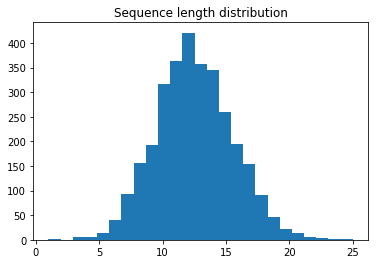

In [19]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

In [26]:
#all unique characters go here
tokens = set(''.join(names[:]))

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)



n_tokens =  31


In [64]:
tokens.sort() # this would put empty line, space ' ' as first (0-index) token. Otherwise all words would end with some character, i.e. BacteriaNamefffffff, padded to the number.

In [65]:
tokens

[' ',
 "'",
 '*',
 '-',
 '.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [66]:
token_to_id = {}

for i in range(n_tokens):
    token_to_id[tokens[i]] = i

In [67]:
token_to_id

{' ': 0,
 "'": 1,
 '*': 2,
 '-': 3,
 '.': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'q': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'x': 28,
 'y': 29,
 'z': 30}

In [68]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [69]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [95]:
print('\n'.join(names[::500]))
print(to_matrix(names[::500]).T)

 
 caminicella
 flexithrix
 litoribacter
 paenicardinium
 saliphilus
 vallitalea
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  5 17 13 18 13  7  9 16 16  5  0  0  0]
 [ 0 10 16  9 28 13 24 12 22 13 28  0  0  0  0]
 [ 0 16 13 24 19 22 13  6  5  7 24  9 22  0  0]
 [ 0 20  5  9 18 13  7  5 22  8 13 18 13 25 17]
 [ 0 23  5 16 13 20 12 13 16 25 23  0  0  0  0]
 [ 0 26  5 16 16 13 24  5 16  9  5  0  0  0  0]]


# II. RNN 

<img src=rnnAML.png width=900>

In [158]:
import keras
from keras.layers import Concatenate,Dense,Embedding

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings

#a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation="tanh")

#a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation="softmax")


In [159]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    """
    #convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    #print(tf.shape(x_t_emb)) #Tensor("Shape_16:0", shape=(2,), dtype=int32)
    #print(tf.shape(h_t))    #Tensor("Shape_16:0", shape=(2,), dtype=int32)
    
    #concatenate x embedding and previous h state
    #x_and_h = Concatenate()([x_t_emb, h_t])###YOUR CODE HERE <keras.layers.merge.Concatenate object at 0x7f87e5bfc6a0>
    x_and_h = tf.concat([x_t_emb, h_t], 1)
    #compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    #get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas,h_next

In [160]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) #initial hidden state

for t in range(MAX_LENGTH): #for every time-step 't' ( each character)
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

In [161]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [162]:
from keras.objectives import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))
optimize = tf.train.AdamOptimizer().minimize(loss)

In [163]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

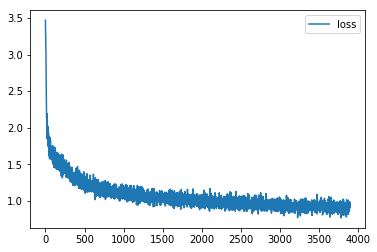

In [165]:
for i in range(2000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

# III. Sampling

In [166]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [178]:
def generate_sample(seed_phrase=None,max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    
    if seed_phrase==None:
        seed_phrase=' '
    else:
        seed_phrase=' ' + str(seed_phrase).strip().lower()
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [176]:
for i in range(3):
    print(str(i+1) + ". " + generate_sample())

1.  ulusiflerodhigum        
2.  thyyomoculii            
3.  muhrococccelis          


In [90]:
for i in range(5):
    print(str(i+1) + ". " + generate_sample())

1.  meslochawilum           
2.  rutrimicrobocatsisps    
3.  hulichadmeus            
4.  cindiviia               
5.  strastroa               


In [180]:
for i in range(3):
    print(str(i+1) + ". " + generate_sample("trump"))

1.  trumpindis              
2.  trumporibacter          
3.  trumporia               


In [181]:
for i in range(16):
    print(str(i+1) + ". " + generate_sample("trump"))

1.  trumperifaponspsia      
2.  trumpora                
3.  trumpodispora           
4.  trumphanus              
5.  trumpiratriun           
6.  trumpris                
7.  trumprica               
8.  trumphahrocchibum       
9.  trumphaera              
10.  trumprewella            
11.  trumpirilis             
12.  trumpobaciluda          
13.  trumpsansur             
14.  trumphelnatochter       
15.  trumphibrio             
16.  trumpiribacter          


In [193]:
for i in range(3):
    print(str(i+1) + ". " + generate_sample("stec"))

1.  steconemocosomaspia     
2.  stecybacter             
3.  stecniplilus            


In [194]:
for i in range(10):
    print(str(i+1) + ". " + generate_sample("stec"))

1.  stectkinim              
2.  steconimpta             
3.  steceholeum             
4.  stecnopela              
5.  stecynoprermio          
6.  stecasa                 
7.  stecthrovum             
8.  stecen                  
9.  steccibacter            
10.  stecocoga               


# Results

Some of my picks:
- methynocycomoris
- corevibacter
- temia
- mindomorispora